In [1]:
# Author: Volker Hoffmann, SINTEF <volker.hoffmann@sintef.no> <volker@cheleb.net>
# Update: 03 May 2018

Previously, we have a used decision tree to illustrate how machine learning can be used in a simple load forecasting scenario. Unfortunately, the load forecasting didn't work very well as the predictor somehow managed to only predict a median value of power consumption for a given day.

We proposed that this was due to lack of proper features to learn from. Post-hoc, we also argued that this kind of performance shouldn't be unexpected because power consumption over a 24 hour cycle can vary widldly when comparing different days across weeks, months, and years.

In this notebook, we will improve our forecasting accuracy by including lagged features. In other words, in addition to using features like the day of the week, we also simply include the observed power consumption over the past few hours. While this dramatically improves accuracy, we caution that the model is not cross-validated and may be over- or underfitting. In future notebooks, we will explore how to mitigate these issues.

Again, let us start by configuring our environment.

In [2]:
%matplotlib inline

In [3]:
import matplotlib as mpl; mpl.rcParams['figure.dpi'] = 72
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import datetime
import sklearn.tree

In [4]:
plt.style.use('ggplot')
# plt.style.use('dark_background')

# Load UkDale

Again, we'll use `Pandas` to load our time series from disk and hold it for us in a nice interface.

As before, we will also downsample the six second obserbations to an hourly representation.

If you need to recall these steps, please have a look at https://github.com/vhffm/PythonForDataScience/blob/master/01-ExploreTimeSeries.ipynb.

In [5]:
# To convert this to the native Pandas data, we define this function.
def dateparse(time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

In [6]:
# basedir = '/storage2/energy/ukdale'
# basedir = '/Users/volker/Work_Sintef/DatasetsPublic/UkDale'
# basedir = '/home/volker/OneDrive_SINTEF/Datasets/UkDale'
basedir = '/data/public/ukdale'

# fname = "%s/house_%i_mainsonly/channel_1.dat" % (basedir, 1)
fname = "%s/house_%i/channel_1.dat" % (basedir, 1)

In [7]:
%%time
# https://stackoverflow.com/questions/34122395/reading-a-csv-with-a-timestamp-column-with-pandas
df = pd.read_csv(fname, parse_dates=True, date_parser=dateparse, \
                 names=[ 'timestamp', 'power_VA' ], index_col='timestamp', header=None, sep=' ')

CPU times: user 45.4 s, sys: 2.75 s, total: 48.1 s
Wall time: 46.9 s


In [8]:
# 1 - resample hourly
#     this is the average apparent power reading over one hour
#     in other words, an apparent power consumption of an VAh/hour
df_hourly = df.resample('1h').mean()

# 2 - drop nan
df_hourly.dropna(inplace=True)

# 2 - we need the timestamp as a column to use the .dt accesor
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dt.html#pandas-series-dt
df_hourly['timestamp'] = df_hourly.index

# Prepare Feature Vectors

We wish to test what kind of features have the most impact on algorithm performance. This requires some flexibility in the construction of the feature vectors to be used. To quickly allow construction (of different kinds) of feature vectors, we therefore write a little convenience function.

The following function `mktrain` takes as arguments the kinds of features we may want and returns a suitable dataframe with the features and the prediction target. Possible features are the three features used before (time of day, day of week, and month of year) as well as the number of lagged demand values we wish to use.

In [9]:
def mktrain(df_in, columns=['hour_of_day', 'day_of_week', 'month_of_year'], nlags=12):
    
    # init
    data = {}
    feature_columns = []
    
    data['timestamp'] = df_in.index
    
    # main columns
    if 'hour_of_day' in columns:
        data['hour_of_day'] = df_in['timestamp'].dt.hour
        feature_columns.append('hour_of_day')
    if 'day_of_week' in columns:
        data['day_of_week'] = df_in['timestamp'].dt.dayofweek
        feature_columns.append('day_of_week')
    if 'month_of_year' in columns:
        data['month_of_year'] = df_in['timestamp'].dt.month
        feature_columns.append('month_of_year')
    
    # compute lags
    lags = []
    for nlag in range(1,nlags+1):
        lag = df_in.power_VA
        # np.append(power_VA_m1[::-1], np.ones(1) * np.nan)[::-1][:-1]
        # np.append(power_VA_m2[::-1], np.ones(2) * np.nan)[::-1][:-2]
        lag = np.append(lag[::-1], np.ones(nlag) * np.nan)[::-1][:-nlag]
        lags.append(lag)
    
    # append lags
    for nlag in range(1,nlags+1):
        data["m%02d" % nlag] = lags[nlag-1]
        feature_columns.append("m%02d" % nlag)
        
    # add prediction target
    data['power_actual_VA'] = df_in['power_VA']
    
    # build output dataframe
    df_out = pd.DataFrame(data = data)
    
    # drop cols with NaNs (coming from lags)
    df_out.dropna(inplace=True)
    
    return df_out, feature_columns

We now execute the function with its default set of arguments. This returns a feature vector looking as follows.

In [10]:
# execute function
df_learning, _ = mktrain(df_hourly)

# let's see what our feature vector/dataframe looks like
df_learning.head(3).T

timestamp,2012-11-10 10:00:00,2012-11-10 11:00:00,2012-11-10 12:00:00
day_of_week,5,5,5
hour_of_day,10,11,12
m01,392.411,1204.34,855.325
m02,260.917,392.411,1204.34
m03,146.969,260.917,392.411
m04,187.295,146.969,260.917
m05,153.618,187.295,146.969
m06,163.3,153.618,187.295
m07,154.566,163.3,153.618
m08,173.122,154.566,163.3


So, our dataframe contains the familiar feature columns (shown here as rows because we have transposed the view) `hour_of_day`, `day_of_week`, `month_of_year` as well as the target columns `power_actual_VA`. By calling the function `mktrain` with its default arguments, we also added the columns `m01` through `m12` to the dataframe. These are lagged values of `power_actual_VA`. In otherwords, `power_actual_VA` at timestamp `2012-11-10 10:00:00` is the same as the value for `m01` for timestamp `2012-11-10 11:00:00` (one hour later).

# Model Training w/ Different Feature Vectors

We now wish the train models on different feature vectors by selecting subsets from the above. To do this efficiently, we again write a convenience function which we call `train_and_eval` that takes the number of feature columns we're intersted as a arguments, trains the models, evaluates the model (in terms of accuracy percentage between actual and predicted consumption) and then returns a modified version of the dataframe which holds the results.

In [11]:
def train_and_eval(df, columns_all):
    
    r = sklearn.tree.DecisionTreeRegressor(max_depth=16)
    
    y_train = np.asarray(df[['power_actual_VA']])
    for icolumns, columns in enumerate(columns_all):
        
        # train model
        x_train = np.asarray(df_learning[columns])
        r.fit(x_train, y_train)
        
        # predict
        power_predict_index = "power_predicted_VA_%02d" % (icolumns+1)
        df_learning[power_predict_index] = r.predict(x_train)
        
        # compute accuracy percentage
        power_difference_pct_index = "power_difference_pct_%02d" % (icolumns+1)
        df[power_difference_pct_index] = \
            ( (df_learning['power_actual_VA'] - df_learning[power_predict_index]) / \
               df_learning[power_predict_index] ) * 100.0

    return df

We now call the above function for six different feature vectors.

1. Use **only the seasonal features** (`hour_of_day`, `day_of_week`, `month_of_year`) as we've done before
2. Use only the **past two hours** of consumption data
3. Combine the **seasonal features** with the **past two** hours 
4. Combine the **seasonal features** with the **past four** hours 
5. Combine the **seasonal features** with the **past six** hours
6. Combine the **seasonal features** with the **past eight** hours

In [12]:
labels = [ 'Seasonal Features', \
           '2 Past Hours', \
           'Seasonal + 2 Past Hours', \
           'Seasonal + 4 Past Hours', \
           'Seasonal + 6 Past Hours', \
           'Seasonal + 8 Past Hours' ] 

columns_all = [ ['month_of_year', 'day_of_week', 'hour_of_day'], \
                ['m01','m02'], \
                ['month_of_year', 'day_of_week', 'hour_of_day','m01','m02'], \
                ['month_of_year', 'day_of_week', 'hour_of_day','m01','m02','m03','m04'], \
                ['month_of_year', 'day_of_week', 'hour_of_day','m01','m02','m03','m04','m05','m06'], \
                ['month_of_year', 'day_of_week', 'hour_of_day','m01','m02','m03','m04','m05','m06','m07','m08'] ]

In [13]:
df_learning = train_and_eval(df_learning, columns_all)

# Model Performance (Accuracy)

The resulting dataframe contains prediction results for all feature vectors. That is to say, the prediction results `power_predicted_VA_<INT>` and accuracy `power_difference_pct_<INT>`. Here, `<INT>` links to the order of the input feature vector (`columns_all` in the above cell).

In [14]:
df_learning.head(3).T

timestamp,2012-11-10 10:00:00,2012-11-10 11:00:00,2012-11-10 12:00:00
day_of_week,5,5,5
hour_of_day,10,11,12
m01,392.411,1204.34,855.325
m02,260.917,392.411,1204.34
m03,146.969,260.917,392.411
m04,187.295,146.969,260.917
m05,153.618,187.295,146.969
m06,163.3,153.618,187.295
m07,154.566,163.3,153.618
m08,173.122,154.566,163.3


Of course, looking at a slice of the dataframe is not particularly illuminating in itself. Let us instead plot the predicted time series as well as the actual time series for the three first feature vectors (only seasonal information, only two past hours, seasonal information + two past hours).

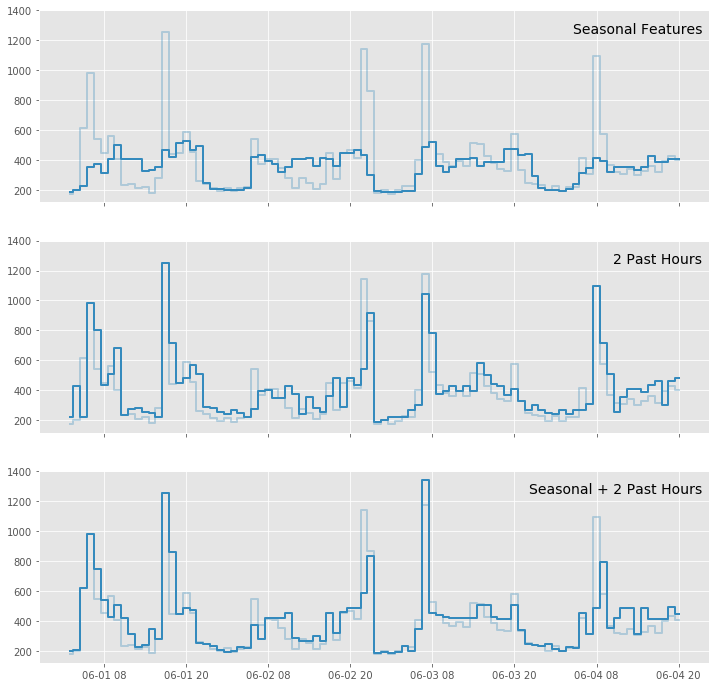

In [15]:
# plot a few days
mask = (df_learning.index >= '2015-06-01 03:00:00') & (df_learning.index < '2015-06-04 21:00:00')

#  setup figure
fig, axarr = plt.subplots(3,1,sharex=True,sharey=True)
fig.set_size_inches(12,12)

for ii, nn in enumerate([ 1, 2, 3 ]):
    ax = axarr.flatten()[ii]
    ax.step(df_learning[mask].timestamp, df_learning[mask].power_actual_VA, lw=2.0, color='#348ABD', where='mid', alpha=0.3)
    ax.step(df_learning[mask].timestamp, df_learning[mask]["power_predicted_VA_%02d" % nn], lw=2.0, color='#348ABD', where='mid')
    # ax.annotate(labels[ii], (0.5,0.5), xycoords='axis')
    ax.text(0.99, 0.94, labels[ii], transform=ax.transAxes, fontsize=14, va='top', ha='right')

pass

We note:

1. Just using seasonal features (top panel) is not very good, but we knew that from before.
2. Using just the last two hours (middle panel) and not caring about the time in the year is already better.
3. Combining the two (bottom row) appears to be even better, although the improvement is minor.

However, just looking at a thin slice of the data is not a very good way to objectively asses the quality of our models. Instead, we should look at the overall distribution of accuracy for all models and over the entire time-horizon.

To do this, we extract statistics on the accuracy (`power_difference_pct_<INT>`) as follows.

Remember that `<INT> = [ 01, 02, ..., 06 ]` refers to the ordered list of feature vectors.

In [16]:
df_learning[['power_difference_pct_01', \
             'power_difference_pct_02', \
             'power_difference_pct_03', \
             'power_difference_pct_04', \
             'power_difference_pct_05', \
             'power_difference_pct_06']].describe().T

,count,mean,std,min,25%,50%,75%,max
power_difference_pct_01,37831.0,-1.923279e-16,52.150986,-77.981465,-30.717079,-9.889942,12.994078,597.588033
power_difference_pct_02,37831.0,1.586705e-15,37.172079,-79.431111,-18.605125,-4.245713,4.607580,588.818350
power_difference_pct_03,37831.0,5.433264e-15,28.600167,-77.443476,-11.090649,0.000000,3.818463,561.455407
power_difference_pct_04,37831.0,8.654756e-16,27.910108,-76.510591,-11.031493,0.000000,4.325149,419.175249
power_difference_pct_05,37831.0,-3.558067e-15,27.749002,-82.424540,-11.123189,0.000000,4.606740,389.235004
power_difference_pct_06,37831.0,-2.163689e-15,28.051749,-76.492764,-11.369915,0.000000,4.879785,443.117033


We note that standard deviation (`std`) for the first three models (for which we have plotted part of the time series above) decreases. This is in line with our observation that using only seasonal features (`power_difference_pct_01`, top panel in the figure above) gives the worst accuracy. Using just the two past hours  (`power_difference_pct_02`, middle panel) does a bit better. Using seasonal features as well as the past tow hours of load data `(power_difference_pct_03`, bottom panel) does even better.

Note that the mean (and the median, for that matter) are very close `0`. This does **not** mean that all models are amazing. We must remember the way we define accuracy (the difference between predicted and actual power demand in percent) can be negative as well as positive. If(!) the model isn't biased to either under- or overestimates, this will lead to a distribution centered somewhere close to zero.

To really understand the overall accuracy, we need to look at the full distribution of difference percentages.

However, plotting and comparing distributions is a bit tedious, so we will instead plot various percentile ranges.

In [17]:
# extract percentiles
percentiles_all = []
for ii, _ in enumerate(columns_all):
    idx = "power_difference_pct_%02d" % (ii+1)
    accuracy = np.asarray(df_learning[idx])
    abs_accuracy = np.abs(accuracy)
    
    p10, p25, p50, p75, p90 = \
        np.percentile(accuracy, 10), \
        np.percentile(accuracy, 25), \
        np.percentile(accuracy, 50), \
        np.percentile(accuracy, 75), \
        np.percentile(accuracy, 90)
    percentiles_all.append(np.array([p10, p25, p50, p75, p90]))
    
    # debug
    # print("%.1f %.1f %.1f %.1f %.1f" % (p10, p25, p50, p75, p90))   

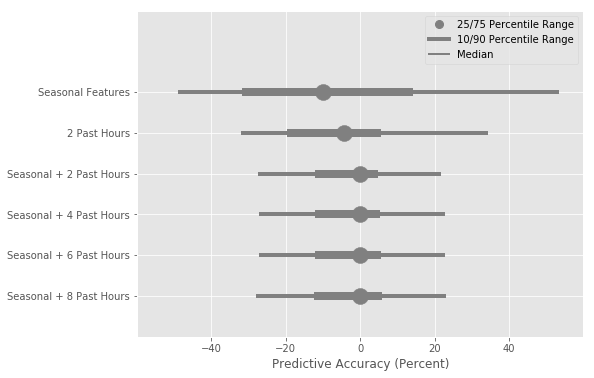

In [18]:
# setup figure
fig, ax = plt.subplots(1,1)
# fig.set_size_inches(6,5)
fig.set_size_inches(8,6)

# plot the accuracy percentile ranges for all feature columns variations we used
for kk, percentiles in enumerate(percentiles_all[::-1]):
    kk += 1    
    ax.plot([percentiles[0], percentiles[-1]], [kk, kk], lw=4, zorder=1, color='grey') # 10-90
    ax.plot([percentiles[1], percentiles[-2]], [kk, kk], lw=8, zorder=2, color='grey') # 25-75
    ax.scatter(percentiles[2], kk, s=16**2, zorder=3, color='grey')

# legend
h1, = ax.plot([], linestyle='none', \
              markerfacecolor='grey', \
              markeredgecolor='grey', \
              marker='o', markersize=8)
h2, = ax.plot([], lw=4, color='grey')
h3, = ax.plot([], lw=2, color='grey')

legend = ax.legend([ h1, h2, h3 ], \
                   [ '25/75 Percentile Range', \
                     '10/90 Percentile Range', \
                     'Median'], \
                   fontsize='medium', frameon=True)
plt.setp(legend.get_texts(), color='k')

# labels, etc
ax.set_xlabel('Predictive Accuracy (Percent)')
ax.set_ylim([0,8])
ax.set_xlim([-60,60])
ax.set_yticks([1,2,3,4,5,6])
ax.set_yticklabels(labels[::-1])
ax.set_xticks([-40,-20,0,20,40])

pass

For each model, the above figure shows the median accuracy as well as the 25/75 percentile and 10/90 percentile ranges.

Recall that, in a dataset, exactly half the datapoints have values smaller (and larger) than the median. Further, half the points have values falling between the 25/75 percentiles. Finally, 80 percent of all points have values between the 10 and 90 percentiles.

So, the figure tells us that

1. Just using seasonal features performs the worst (the spread is largest)
2. Using just the past two hours is already better (the spread is smaller)
3. Using the past two hours as well as seasonal features is even better (the spead is even smaller)
4. Adding further lags (four, six, and eight hours) does not improves accuracy (spread does not change)
5. At this point, accuracy is within thirty percent for most (80 percent) of forecasts
6. The seasonal only and lag only models tend to underestimate the demand (median below zero)
7. None of the other models bias towards over- or underestimation (median around zero)
8. For all (except season only) models, the most accuracy 25 percent are better when the model underestimates (the 25/75 percentile range is lopsided left)

In conclusion, if we can live with the fact that most (80 percent of) predictions will be within an accuracy band of 30 percent, the third model (seasonal features plus demand from the past two hours) is the one we want to deploy. Adding more lagged demand values does not add anything, but makes training take longer.

# What's Next?

- So far, we train on the same samples that we validate on. While this is fine for demonstration purposes, it also means that we are not evaluation how well our model generalizes. In other words, we only know how well the model works with the data it's already seen. In the real world, this is a bit of a silly scenario. We need to test how our model will cope with data is hasn't seen yet. This is usually done via a process called cross valiation where the data is split into a training set (which the algorithm is trained on) and a testing set (against which it is evaluated). 

- We may be over- or underfitting to our data. If we overfit, the model becomes exceedingly good at predicting situations it's already seen, but very bad at generalizing. If we underfit, the models is exceedingly simple and does not actually manage to capture any of the trends in the underlying data. While we probably don't underfit, we may very well be overfitting. One way of determining whether we're overfitting is to assess model performance in cross-validation.

- So far, we have only tried a decision tree regression with a mysterious parameter called `max_depth`. Clearly, we should explain what a decision tree is, what this parameter does, how its choice influence accuracy, what other parameters there, and how different kinds of learning methods may perform. 